# Web Scrape

### Import Libraby & Init url

In [37]:
import requests
import urllib.request
import time
import pandas as pd
from bs4 import BeautifulSoup
import re

# Model
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.datasets import load_files
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# display progress bar (tqdm>=4.23.4 | pandas==0.24.0)
from tqdm import tqdm_notebook as tqdm 

#evaluaitotn 
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

In [72]:
# movie_data = load_files(r"./datastore\txt_sentoken")

In [2]:
# init request
baseUrl = "http://www.it.kmitl.ac.th/~teerapong/news_archive"
homeUrl = "http://www.it.kmitl.ac.th/~teerapong/news_archive/index.html"
response = requests.get(homeUrl)

### Extract Month URL

In [3]:
# parse html
soup = BeautifulSoup(response.text, "html.parser", from_encoding="utf-8")

C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:177: UserWarning: You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.
  warnings.warn("You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.")


In [4]:
# create month url
li_group = soup.findAll('li')
month_url_group = [f"{baseUrl}/{li.find('a')['href']}" for li in li_group]

### Extract Article Properties 

In [75]:
# use url each month to fetch article
article_category = []
article_title = []
article_url = []

for month in month_url_group: # loop each month 

    # init soup
    month_resp = requests.get(month);
    soup = BeautifulSoup(month_resp.text, "html.parser", from_encoding="utf-8")
    
    # append category
    category_group = soup.findAll('td', {'class': 'category'});
    for category in category_group:
        # article category not available -> skip
        if category.getText().strip() == "N/A": continue
        article_category.append(category.getText().strip())
        
    # append title & url
    title_group = soup.findAll('td', {'class': 'title'});
    for title in title_group:
        # article title not available -> skip
        if title.getText().strip() == "Article no longer available in archive": continue
        article_title.append(title.getText().strip())
        article_url.append(f"{baseUrl}/{title.find('a')['href']}")

        
# display article properties length (check length is match)
print("Category: " + str(len(article_category)))
print("Title: " + str(len(article_title)))
print("Url: " + str(len(article_url)))

C:\ProgramData\Anaconda3\lib\site-packages\bs4\__init__.py:177: UserWarning: You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.
  warnings.warn("You provided Unicode markup but also provided a value for from_encoding. Your from_encoding will be ignored.")


Category: 1408
Title: 1408
Url: 1408


### Extract Article Content

In [78]:
# use articule url to fetch article content
article_content = []

with tqdm(total=len(article_url)) as pbar: # init progress bar
    

    for article in article_url:  # loop each article

        try: # catch content not avaliable
            
            article_resp = requests.get(article);
            soup = BeautifulSoup(article_resp.text, "html.parser", from_encoding="utf-8")
            current_content = []

            article_group = soup.findAll('p')
            for content in article_group[:-1]:

                # check <p> is empty?
                if (content.text == ""): continue
                current_content.append(content.text.rstrip("\n\r"))

            # join each <p> to raw string and append to article_content
            article_content.append(''.join(current_content))
            
        except:
            article_content.append("")
        
        # update progress bar
        pbar.update(1)

# display article content length
print("Content: " + str(len(article_content)))


Content: 1408


### Write Files

In [79]:
# write article_title.txt
with open("./datastore/article_title.txt", "w", encoding="utf-8") as file:
    for row in article_title:
        file.write("%s\n" % row)
    file.close()

# write article_category.txt
with open("./datastore/article_category.txt", "w", encoding="utf-8") as file:
    for row in article_category:
        file.write("%s\n" % row)
    file.close()
    
# write article_content.txt
with open("./datastore/article_content.txt", "w", encoding="utf-8") as file:
    for row in article_content:
        file.write("%s\n" % row)
    file.close()

### Read File

In [15]:
# read article_title.txt
with open("./datastore/article_title.txt", "r", encoding="utf-8") as file:
    title_raw = file.read().splitlines()
    file.close()
    
with open("./datastore/article_category.txt", "r", encoding="utf-8") as file:
    category_raw = file.read().splitlines()
    file.close()
    
# read article_title.txt
with open("./datastore/article_content.txt", "r", encoding="utf-8") as file:
    content_raw = file.read().splitlines()
    file.close()

In [16]:
# init article DataFrame
title_data = title_raw
content_data = content_raw
category_data = category_raw

### Text Preprocessing
remove special charectors and numbers from text

- if you have error `IOPub data rate exceeded.` run notebook with `jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10` in terminal

In [17]:
documents = []
stemmer = WordNetLemmatizer()
for content in content_data:
    # remove all the special characters
    document = re.sub(r'\W', ' ', str(content))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Converting to Lowercase
    document = document.lower()
    
    # Lemmatization
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)
  
# show example
print("original: " + content_data[0] + "\n")
print("after process: " + documents[0])

original: The sporting industry has come a long way since the â60s. It has carved out for itself a niche with its roots so deep that I cannot fathom the sports industry showing any sign of decline any time soon - or later.The reason can be found in this seemingly subtle difference - other industries have customers; the sporting industry has fans. Vivek RanadivÃ©, leader of the ownership group of the NBAâs Sacramento Kings, explained it beautifully, âFans will paint their face purple, fans will evangelize. ... Every other CEO in every business is dying to be in our position â theyâre dying to have fans.âWhile fan passion alone could almost certainly keep the industry going, leagues and sporting franchises have decided not to rest on their laurels. The last few years have seen the steady introduction of technology into the world of sports - amplifying fansâ appreciation of games, enhancing athletesâ public profiles and informing their training methods, even influencing ho

### Converting Text

In [18]:
# Bag of words
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
bow_process = vectorizer.fit_transform(documents).toarray()

In [19]:
# TFIDF
tfidfconverter = TfidfTransformer()
tfidf = tfidfconverter.fit_transform(bow_process).toarray()

### Training and Testing Sets

In [20]:
import numpy as np
import pickle 

In [21]:
X_train, X_test, y_train, y_test = train_test_split(tfidf, category_data, test_size=0.2, random_state=0)

Random Forest Model

In [22]:
classifier = RandomForestClassifier(n_estimators=1000, random_state=np.random)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False,
            random_state=<module 'numpy.random' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\numpy\\random\\__init__.py'>,
            verbose=0, warm_start=False)

In [23]:
y_pred = classifier.predict(X_test)

In [24]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[ 92   1   2]
 [  2 106   0]
 [  1   3  75]]
              precision    recall  f1-score   support

    business       0.97      0.97      0.97        95
       sport       0.96      0.98      0.97       108
  technology       0.97      0.95      0.96        79

   micro avg       0.97      0.97      0.97       282
   macro avg       0.97      0.97      0.97       282
weighted avg       0.97      0.97      0.97       282

0.9680851063829787


## Naive Bayes classifier 

In [25]:
nb_clf = MultinomialNB()

In [26]:
nb_clf.fit(X_train, y_train)
predicted = nb_clf.predict(X_test)
np.mean(predicted == y_test)

0.975177304964539

In [27]:
print(confusion_matrix(y_test,predicted))
print(classification_report(y_test,predicted))
print(accuracy_score(y_test, predicted))

[[ 93   0   2]
 [  3 105   0]
 [  0   2  77]]
              precision    recall  f1-score   support

    business       0.97      0.98      0.97        95
       sport       0.98      0.97      0.98       108
  technology       0.97      0.97      0.97        79

   micro avg       0.98      0.98      0.98       282
   macro avg       0.97      0.98      0.98       282
weighted avg       0.98      0.98      0.98       282

0.975177304964539


## Kneighbor classifier 

In [65]:
from sklearn import metrics ,  neighbors
from matplotlib.colors import ListedColormap

In [56]:
#define the model
kn_clf = KNeighborsClassifier(n_neighbors=3, weights='uniform')
# train 
kn_clf.fit(X_train, y_train)
predicted = kn_clf.predict(X_test)
np.mean(predicted == y_test)

0.6453900709219859

In [53]:
print('The accuracy of the KNN is',metrics.accuracy_score(predicted,y_test)*100, 'percent')

The accuracy of the KNN is 64.53900709219859 percent


In [29]:
print(confusion_matrix(y_test,predicted))
print(classification_report(y_test,predicted))
print(accuracy_score(y_test, predicted))

[[95  0  0]
 [92 16  0]
 [40  1 38]]
              precision    recall  f1-score   support

    business       0.42      1.00      0.59        95
       sport       0.94      0.15      0.26       108
  technology       1.00      0.48      0.65        79

   micro avg       0.53      0.53      0.53       282
   macro avg       0.79      0.54      0.50       282
weighted avg       0.78      0.53      0.48       282

0.5283687943262412


In [30]:
from sklearn.linear_model import SGDClassifier,LogisticRegression

In [31]:
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train)
predicted = sgd_clf.predict(X_test)
np.mean(predicted == y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.9680851063829787

In [32]:
print(confusion_matrix(y_test,predicted))
print(classification_report(y_test,predicted))
print(accuracy_score(y_test, predicted))

[[ 90   4   1]
 [  2 106   0]
 [  0   2  77]]
              precision    recall  f1-score   support

    business       0.98      0.95      0.96        95
       sport       0.95      0.98      0.96       108
  technology       0.99      0.97      0.98        79

   micro avg       0.97      0.97      0.97       282
   macro avg       0.97      0.97      0.97       282
weighted avg       0.97      0.97      0.97       282

0.9680851063829787


In [33]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
predicted = lr_clf.predict(X_test)
np.mean(predicted == y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.9822695035460993

In [34]:
print(confusion_matrix(y_test,predicted))
print(classification_report(y_test,predicted))
print(accuracy_score(y_test, predicted))

[[ 94   0   1]
 [  3 105   0]
 [  0   1  78]]
              precision    recall  f1-score   support

    business       0.97      0.99      0.98        95
       sport       0.99      0.97      0.98       108
  technology       0.99      0.99      0.99        79

   micro avg       0.98      0.98      0.98       282
   macro avg       0.98      0.98      0.98       282
weighted avg       0.98      0.98      0.98       282

0.9822695035460993


# Evaluation 

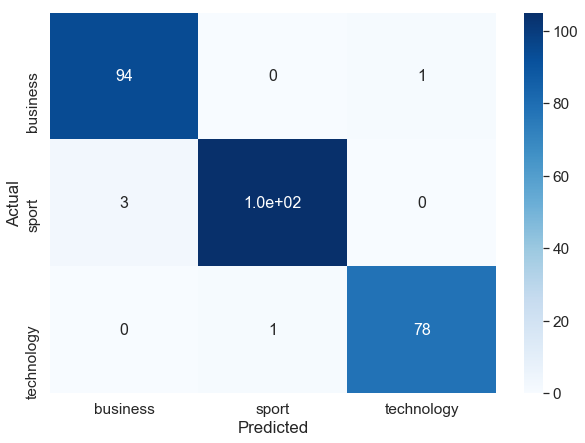

In [38]:
data = confusion_matrix(y_test, predicted)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

In [44]:
auc = roc_auc_score(y_test, probs)
 

ValueError: multiclass format is not supported